# Convection-Diffusion Equation
\begin{equation}\label{1}
\left\{
\begin{array}{rrrrr}
\epsilon u_{xx}+\beta u_x &=&f&\text{in} \ \ \Omega=]-1,1[, \\
u(-1)=u(1)&=&0.&
\end{array}
\right.
\end{equation}

Needed imports:



In [19]:
from numpy import  zeros, ones, linspace, zeros_like, asarray
import numpy as np
from math import cos,pi,exp
from matplotlib import pyplot as plt
from Functions1    import elements_spans  # computes the span for each element
from Functions1    import make_knots      # create a knot sequence from a grid
from Functions1   import quadrature_grid # create a quadrature rule over the whole 1d grid
from Functions1    import basis_ders_on_quad_grid # evaluates all bsplines and their derivatives on the quad grid
from Gauss_Legendre import gauss_legendre
from Functions1   import plot_field_1d # plot a solution for 1d problems
from Functions1    import ErrQuad
from Functions1    import newgrid
from IPython import display

Data set:

In [ ]:
# T=0.5653 #stability constant 
T=0
p=2      #degree
ep=0.6   #\epsilon
c=1      #\beta
ne =10   #number of elemets

Assembling the stiffness matrix using stencil forms:

In [4]:
# ===========================matrix M===============================
def assemble_stiffnessM(nelements, degree, spans, basis, weights, points, matrix):

    # ... sizes
    ne1       = nelements
    p1        = degree
    spans_1   = spans
    basis_1   = basis
    weights_1 = weights
    points_1  = points
    
    k1 = weights.shape[1]
    # ...

    # ... build matrices
    for ie1 in range(0, ne1):
        i_span_1 = spans_1[ie1]
        for il_1 in range(0, p1+1):
            for jl_1 in range(0, p1+1):
                i1 = i_span_1 - p1 + il_1
                j1 = i_span_1 - p1 + jl_1

                v = 0.0
                for g1 in range(0, k1):
                    bi_0 = basis_1[ie1, il_1, 0, g1]
                    bi_x = basis_1[ie1, il_1, 1, g1]                    

                    bj_0 = basis_1[ie1, jl_1, 0, g1]
                    bj_x = basis_1[ie1, jl_1, 1, g1]                    

                    wvol = weights_1[ie1, g1]

                    v +=(bi_x * bj_x) * wvol

                matrix[i1, j1]  += v

    return matrix

In [5]:
# ===========================matrix N=============================== 
def assemble_stiffnessN(nelements, degree, spans, basis, weights, points, matrix):

    # ... sizes
    ne1       = nelements
    p1        = degree
    spans_1   = spans
    basis_1   = basis
    weights_1 = weights
    points_1  = points
    
    k1 = weights.shape[1]

    # ...

    # ... build matrices
    for ie1 in range(0, ne1):
        i_span_1 = spans_1[ie1]
        for il_1 in range(0, p1+1):
            for jl_1 in range(0, p1+1):
                i1 = i_span_1 - p1 + il_1
                j1 = i_span_1 - p1 + jl_1

                v = 0.0
                for g1 in range(0, k1):
                    bi_0 = basis_1[ie1, il_1, 0, g1]
                    bi_x = basis_1[ie1, il_1, 1, g1]                    

                    bj_0 = basis_1[ie1, jl_1, 0, g1]
                    bj_x = basis_1[ie1, jl_1, 1, g1]                    

                    wvol = weights_1[ie1, g1]

                    v += (bi_0 * bj_x) * wvol

                matrix[i1, j1]  += v

    return matrix      

In [6]:
# ===========================Assembly procedure for the rhs===============================    
def assemble_rhs(f, nelements, degree, spans, basis, weights, points, rhs):

    # ... sizes
    ne1       = nelements
    p1        = degree
    spans_1   = spans
    basis_1   = basis
    weights_1 = weights
    points_1  = points
    
    k1 = weights.shape[1]
    # ...

    # ... build rhs
    for ie1 in range(0, ne1):
        i_span_1 = spans_1[ie1]
        for il_1 in range(0, p1+1):
            i1 = i_span_1 - p1 + il_1

            v = 0.0
            for g1 in range(0, k1):
                bi_0 = basis_1[ie1, il_1, 0, g1]
                bi_x = basis_1[ie1, il_1, 1, g1]  

                x1    = points_1[ie1, g1]
                wvol  = weights_1[ie1, g1]

                v += (bi_0+T*bi_x) * f(x1) * wvol

            rhs[i1] += v

    return rhs

Exact Solution:

In [7]:
x=np.linspace(-1,1,200)
c1=(exp(1/ep)+exp(-1/ep))/(exp(1/ep)-exp(-1/ep))
c2=-2/(exp(1/ep)-exp(-1/ep))
exact = lambda x: c1+c2*exp(x/ep)+x
h=[exact(e) for e in x]

Non-uniform subdivision:

In [8]:
#---------------------------------------------
#grid =np.zeros([ne+1,1])
#for i in range(ne+1):
 #   grid[i]=-1+2*np.power((i/(ne)),1/4)
#grid=np.squeeze(grid) 
#--------------------------------------------
#grid1  = linspace(-1., 1., ne+1)
#alpha=[-0.1,0.058] 
#grid=newgrid(grid1,alpha) 
#--------------------------------------------
#grid=np.array([-1. , -0.876,-0.69, -0.685,-0.31, -0.305, -0.064,  0.35 ,0.351,  0.64,  1. ])
#grid=np.array([-1. , -0.8997,-0.79992, -0.3306,-0.2002, -0.10001, -0.005,  0.1003 ,0.199,  0.8503,  1. ])
#grid=np.array([-1. , -0.9097,-0.8002, -0.3306,-0.2002, -0.10001, 0.0,  0.1003 ,0.200,  0.8503,  1. ])
#grid=np.array([-1. , -0.986,-0.895, -0.775,-0.431, -0.4001, -0.164,  0.235 ,0.251,  0.54,  1. ])
#--------------------------------------------------

Uniform subdivision:


In [9]:
#----------------------------------------------
grid  = linspace(-1., 1., ne+1)
#-----------------------------------------------

Implementation:

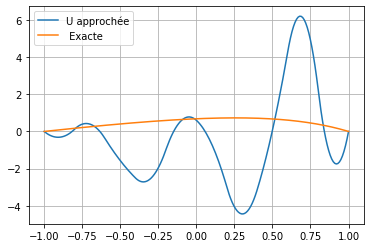

In [12]:
knots = make_knots(grid, p, periodic=False)
spans = elements_spans(knots, p)    
nelements = len(grid) - 1
nbasis    = len(knots) - p - 1

# we need the value a B-Spline and its first derivative
nderiv = 1

# create the gauss-legendre rule, on [-1, 1]
u, w = gauss_legendre( p )

# for each element on the grid, we create a local quadrature grid
points, weights = quadrature_grid( grid, u, w )

# for each element and a quadrature points, 
# we compute the non-vanishing B-Splines
basis = basis_ders_on_quad_grid( knots, p, points, nderiv )
stiffnessM = zeros((nbasis, nbasis))
stiffnessM = assemble_stiffnessM(nelements, p, spans, basis, weights, points, matrix=stiffnessM)
stiffnessN = zeros((nbasis, nbasis))
stiffnessN = assemble_stiffnessN(nelements, p, spans, basis, weights, points, matrix=stiffnessN)

f = lambda x: 1
rhs = zeros(nbasis)
rhs = assemble_rhs(f, nelements, p, spans, basis, weights, points, rhs=rhs)

# apply homogeneous dirichlet boundary conditions
#-----------------------------------------------
rhs = rhs[1:-1]
stiffnessM = stiffnessM[1:-1, 1:-1]
stiffnessN = stiffnessN[1:-1, 1:-1]
#-----------------------------------------------
from scipy.sparse.linalg import cg
u, info = cg( (ep+T)*stiffnessM+c*stiffnessN, rhs, tol=1e-6, maxiter=5000 )
u = [0.] + list(u) + [0.]
u = asarray(u)
plot_field_1d(knots, p, u, nx=200)
plt.plot(x,h,label=' Exacte')
plt.legend()

# Transport Equation $\theta$-Schema
\begin{equation}\label{2}
\left\{
\begin{array}{rrrrr}
\frac{\partial u}{\partial t}+c\frac{\partial u}{\partial x}&=&f&\text{in}\quad [0,T]\times \Omega,\\
u(0,x)&=&u_{0}(x)&\text{in}\quad\Omega, \\
u(t,a)&=&0.&
\end{array}
\right.
\end{equation}

Data set:

In [14]:
T=0.035 #stability constant for ne=100
#T=0.0045 #stability constant for ne=300,500 
teta=0.6  #\theta
p=2 
c=1 
ne =100   #number of elemets
ht=0.01  #the time step
Tmax=1.5 #final time

Assembling the stiffness matrix using stencil forms

In [16]:
# ===========================matrix M===============================
def assemble_stiffnessM(nelements, degree, spans, basis, weights, points, matrix):

    # ... sizes
    ne1       = nelements
    p1        = degree
    spans_1   = spans
    basis_1   = basis
    weights_1 = weights
    points_1  = points
    
    k1 = weights.shape[1]
    # ...

    # ... build matrices
    for ie1 in range(0, ne1):
        i_span_1 = spans_1[ie1]
        for il_1 in range(0, p1+1):
            for jl_1 in range(0, p1+1):
                i1 = i_span_1 - p1 + il_1
                j1 = i_span_1 - p1 + jl_1

                v = 0.0
                for g1 in range(0, k1):
                    bi_0 = basis_1[ie1, il_1, 0, g1]
                    bi_x = basis_1[ie1, il_1, 1, g1]                    

                    bj_0 = basis_1[ie1, jl_1, 0, g1]
                    bj_x = basis_1[ie1, jl_1, 1, g1]                    

                    wvol = weights_1[ie1, g1]

                    v += (bi_0 * bj_0) * wvol

                matrix[i1, j1]  += v
    # ...

    return matrix    

# ===========================matrix N===============================
    
def assemble_stiffnessN(nelements, degree, spans, basis, weights, points, matrix):

    # ... sizes
    ne1       = nelements
    p1        = degree
    spans_1   = spans
    basis_1   = basis
    weights_1 = weights
    points_1  = points
    
    k1 = weights.shape[1]
    
    # ...

    # ... build matrices
    for ie1 in range(0, ne1):
        i_span_1 = spans_1[ie1]
        for il_1 in range(0, p1+1):
            for jl_1 in range(0, p1+1):
                i1 = i_span_1 - p1 + il_1
                j1 = i_span_1 - p1 + jl_1

                v = 0.0
                for g1 in range(0, k1):
                    bi_0 = basis_1[ie1, il_1, 0, g1]
                    bi_x = basis_1[ie1, il_1, 1, g1]                    

                    bj_0 = basis_1[ie1, jl_1, 0, g1]
                    bj_x = basis_1[ie1, jl_1, 1, g1]                    

                    wvol = weights_1[ie1, g1]

                    v += (bi_0 * bj_x) * wvol

                matrix[i1, j1]  += v
    # ...

    return matrix 
# ===========================matrix R=============================== 
def assemble_stiffnessR(nelements, degree, spans, basis, weights, points, matrix):

    # ... sizes
    ne1       = nelements
    p1        = degree
    spans_1   = spans
    basis_1   = basis
    weights_1 = weights
    points_1  = points
    
    k1 = weights.shape[1]
    
    # ...

    # ... build matrices
    for ie1 in range(0, ne1):
        i_span_1 = spans_1[ie1]
        for il_1 in range(0, p1+1):
            for jl_1 in range(0, p1+1):
                i1 = i_span_1 - p1 + il_1
                j1 = i_span_1 - p1 + jl_1

                v = 0.0
                for g1 in range(0, k1):
                    bi_0 = basis_1[ie1, il_1, 0, g1]
                    bi_x = basis_1[ie1, il_1, 1, g1]                    

                    bj_0 = basis_1[ie1, jl_1, 0, g1]
                    bj_x = basis_1[ie1, jl_1, 1, g1]                    

                    wvol = weights_1[ie1, g1]

                    v += (bi_x * bj_0) * wvol

                matrix[i1, j1]  += T*c* v
    # ...

    return matrix
# ===========================matrix S===============================  
def assemble_stiffnessS(nelements, degree, spans, basis, weights, points, matrix):

    # ... sizes
    ne1       = nelements
    p1        = degree
    spans_1   = spans
    basis_1   = basis
    weights_1 = weights
    points_1  = points
    
    k1 = weights.shape[1]

    # ...

    # ... build matrices
    for ie1 in range(0, ne1):
        i_span_1 = spans_1[ie1]
        for il_1 in range(0, p1+1):
            for jl_1 in range(0, p1+1):
                i1 = i_span_1 - p1 + il_1
                j1 = i_span_1 - p1 + jl_1

                v = 0.0
                for g1 in range(0, k1):
                    bi_0 = basis_1[ie1, il_1, 0, g1]
                    bi_x = basis_1[ie1, il_1, 1, g1]                    

                    bj_0 = basis_1[ie1, jl_1, 0, g1]
                    bj_x = basis_1[ie1, jl_1, 1, g1]                    

                    wvol = weights_1[ie1, g1]

                    v += (bi_x * bj_x) * wvol

                matrix[i1, j1]  +=T*c*c*v
    # ...

    return matrix     

Exact Solution:


In [17]:
def U0(x):
    if x>=-1 and x<=1 :
        return 5
    else:
        return 0 
def Uexact(t,x,c) :
        return(U0(x-c*t)) 
    
def plot_exact(knots,degree,t,c,nx=101,color='r'):
    xmin = knots[degree]
    xmax = knots[-degree-1]

    xs = np.linspace(xmin, xmax, nx)
    u=[Uexact(t,e,c) for e in xs]
    plt.plot(xs, u,label='U Exacte')
    plt.legend()

In [18]:
# ===========================non-uniform subdivision===============================
#---------------------------------------------
#grid =np.zeros([ne+1,1])
#for i in range(ne+1):
 #   grid[i]=-5+10*np.power((i/(ne)),(1/4))
#grid=np.squeeze(grid)    
#X =np.zeros([ne+p,1])
#for i in range(ne+p):
   # X[i]=-5+10*np.power((i/(ne+p-1)),(1/4))
#X=np.squeeze(X)
# ===========================uniform subdivision===============================    
#----------------------------------------------
grid  = linspace(-5., 5., ne+1)
X  = linspace(-5., 5., ne+p)
#-----------------------------------------------
# ==========================================================

Implementation:

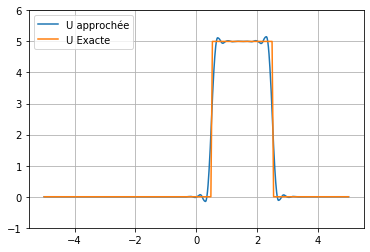

In [20]:
f=[U0(e) for e in X]  
knots = make_knots(grid, p, periodic=False)
spans = elements_spans(knots, p)    
nelements = len(grid) - 1
nbasis    = len(knots) - p - 1

# we need the value a B-Spline and its first derivative
nderiv = 1
# create the gauss-legendre rule, on [-1, 1]
u, w = gauss_legendre( p )

# for each element on the grid, we create a local quadrature grid
points, weights = quadrature_grid( grid, u, w )

# for each element and a quadrature points, 
# we compute the non-vanishing B-Splines
basis = basis_ders_on_quad_grid( knots, p, points, nderiv )
stiffnessM = zeros((nbasis, nbasis))
stiffnessN = zeros((nbasis, nbasis))
stiffnessR = zeros((nbasis, nbasis))
stiffnessS = zeros((nbasis, nbasis))
stiffnessM = assemble_stiffnessM(nelements, p, spans, basis, weights, points, matrix=stiffnessM)
stiffnessN = assemble_stiffnessN(nelements, p, spans, basis, weights, points, matrix=stiffnessN)
stiffnessR = assemble_stiffnessR(nelements, p, spans, basis, weights, points, matrix=stiffnessR)
stiffnessS = assemble_stiffnessS(nelements, p, spans, basis, weights, points, matrix=stiffnessS)
#------------------------------------------------------------------------------------------
z=0
temps=[]
Err=[]
while z<=Tmax:
    G=stiffnessM+stiffnessR+np.dot(ht*teta,stiffnessS+stiffnessN)
    # apply homogeneous dirichlet boundary conditions
    G[0,:]=0
    G[0,0]=1
    S=np.dot(stiffnessM+stiffnessR+ht*(teta-1)*(stiffnessS+stiffnessN),f[:])
    S[0]=0
    from scipy.sparse.linalg import gmres
    unew, info = gmres( G, S, tol=1e-6, maxiter=5000 )
    unew = list(unew) 
    unew = asarray(unew)
    o=[Uexact(z,e,c) for e in X]
    #Err1=ErrQuad (unew,o)
    #temps.append(z)
    #Err.append(Err1)
    display.clear_output(wait=True)
    plot_field_1d(knots, p, unew, nx=1000)
    plot_exact(knots,p,z,c,nx=200,color='r')
    plt.ylim([-1,6])
    plt.pause(0.005)
    f=unew
    z=z+ht
# ===========================Plot Error=============================== 
#Max=max(Err)
#plt.plot(temps,Err,label='MaxErr=%1.4f'%Max)   
#plt.title('Teta=%1.2f'%teta )
#plt.legend()
#plt.grid()    
#print(Max)

# Transport Equation Runge-Kutta

Data set:

In [21]:
T=0.035 #stability constant for ne=100
#T=0.0045 #stability constant for ne=300,500 
p=2 
c=1 
ne =100   #number of elemets
ht=0.01  #the time step
Tmax=1.5 #final time

Implementation:


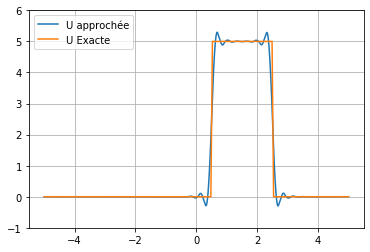

In [23]:
f=[U0(e) for e in X]
knots = make_knots(grid, p, periodic=False)
spans = elements_spans(knots, p)    
nelements = len(grid) - 1
nbasis    = len(knots) - p - 1

# we need the value a B-Spline and its first derivative
nderiv = 1

# create the gauss-legendre rule, on [-1, 1]
u, w = gauss_legendre( p )

# for each element on the grid, we create a local quadrature grid
points, weights = quadrature_grid( grid, u, w )

# for each element and a quadrature points, 
# we compute the non-vanishing B-Splines
basis = basis_ders_on_quad_grid( knots, p, points, nderiv )
stiffnessM = zeros((nbasis, nbasis))
stiffnessN = zeros((nbasis, nbasis))
stiffnessR = zeros((nbasis, nbasis))
stiffnessS = zeros((nbasis, nbasis))
stiffnessM = assemble_stiffnessM(nelements, p, spans, basis, weights, points, matrix=stiffnessM)
stiffnessN = assemble_stiffnessN(nelements, p, spans, basis, weights, points, matrix=stiffnessN)
stiffnessR = assemble_stiffnessR(nelements, p, spans, basis, weights, points, matrix=stiffnessR)
stiffnessS = assemble_stiffnessS(nelements, p, spans, basis, weights, points, matrix=stiffnessS)
#----------------------------------------------------------
# apply homogeneous dirichlet boundary conditions
stiffnessM=stiffnessM[1:, 1:]
stiffnessR=stiffnessR[1:, 1:]
stiffnessS=stiffnessS[1:, 1:]
stiffnessN=stiffnessN[1:, 1:]
#----------------------------------------------------
temps=[]
Err=[]
z=0
while z<=Tmax:
    A=np.linalg.inv(stiffnessM+stiffnessR)
    B=-1*np.dot(stiffnessN+stiffnessS,A)
    K1=ht*np.dot(B,f[1:])
    K2=ht*np.dot(B,f[1:]+0.5*K1)
    K3=ht*np.dot(B,f[1:]+0.5*K2)
    K4=ht*np.dot(B,f[1:]+K3)
    unew=f[1:]+1/6*(K1+2*K2+2*K3+K4)
    unew = list(unew) 
    unew = [0.] + list(unew)
    unew = asarray(unew)
    o=[Uexact(z,e,c) for e in X]
    Err1=ErrQuad (unew,o)
    #temps.append(z)
    #Err.append(Err1)
    display.clear_output(wait=True)
    plot_field_1d(knots, p, unew, nx=1000)
    plot_exact(knots,p,z,c,nx=200,color='r')
    plt.ylim([-1,6])
    plt.pause(0.005)
    f=unew
    z=z+ht
# ===========================Plot Error=============================== 
#Max=max(Err)    
#plt.plot(temps,Err,label='MaxErr=%1.4f'%Max)   
#plt.legend()
#plt.grid()    